In this project we will use the California housing data and apply Machine Learning to predict Medium house value

In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [2]:
# fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head(9)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Above we have 10 columns and 20,640 rows. As we look at total_bedrooms we notice 207 districts are mising.

In [6]:
# lets find out how many districts belong to each category
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We notice 1H Ocean has 9,135 districts

Inland has 6,551 districts

Near Ocean has 2,658 districts

Near Bay has 2,290 districts

Island has only 5 districts

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


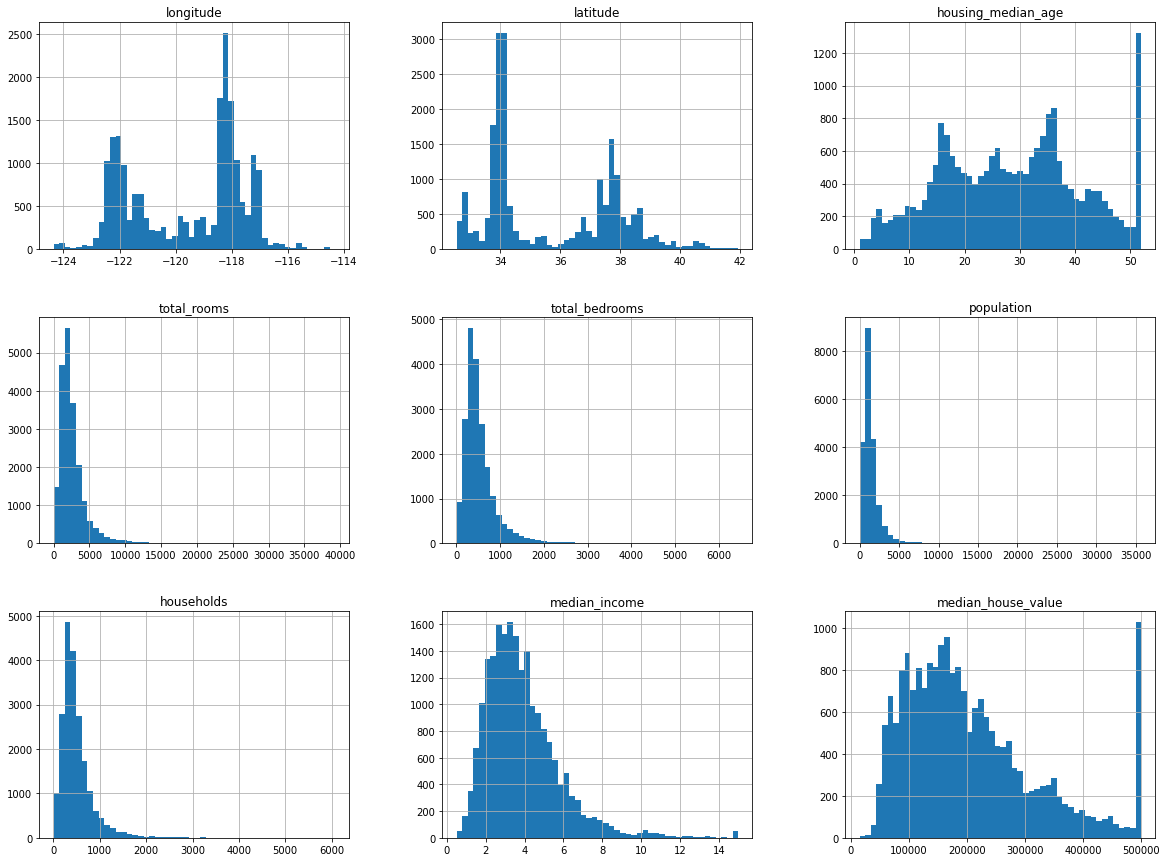

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Plotting the histogram it seems that most of our clolumns are heavy-tailed right. Median_house_value and housing_median_age looks normally distributed. Median_income is close to a normal distribution.

In [9]:
# splitting our data into training and testing before we go any further.
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
# we have 16512 samples for training 
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
# Then 4128 for testing
len(test_set)

4128

In [12]:
# hashing the test sample
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [13]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids. apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [14]:
# creating identifier column for the dataset
housing_with_id = housing.reset_index() # adding an index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [16]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

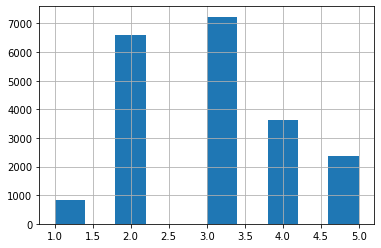

In [17]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.,1.5,3.0,4.5,6.,np.inf],
                              labels=[1,2,3,4,5])
housing["income_cat"].hist()


In [18]:
import sklearn
print(sklearn.__version__)

1.0.2


In [19]:
# using stratified sampeling and insure staritified sample represents the whole data.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
# we see the income_category as the stratified sample income_cat represents the entire data
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [21]:
# remove income_cat so data is back to its original state
for set_ in(strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [22]:
# creating a copy of the training set to play with
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

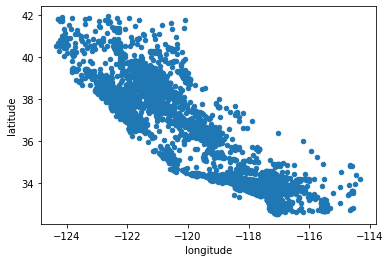

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Looks just like California but all data points look the same. There is no distiction between them

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

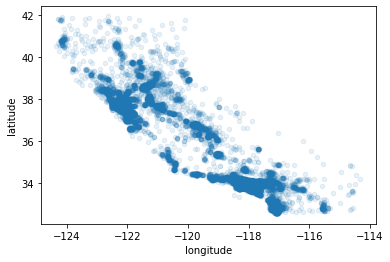

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

The above shows a better visualization that highlights high-density area

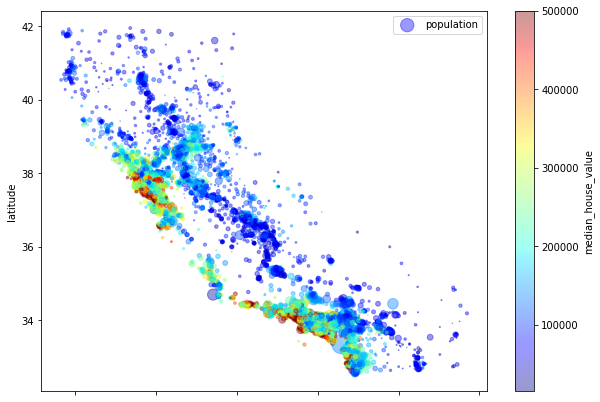

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/ 100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

Above is California housing prices: Red is expensive, Blue is cheap, larger circles indicate areas with a larger population. Housing prices are very much related to location. 

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In the above corrolation matrix, coefficient ranges from -1 to 1. When it is close to 1 it means that there is a strong positive correlation, -1 is strong negative, and 0 is no corrolation.

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

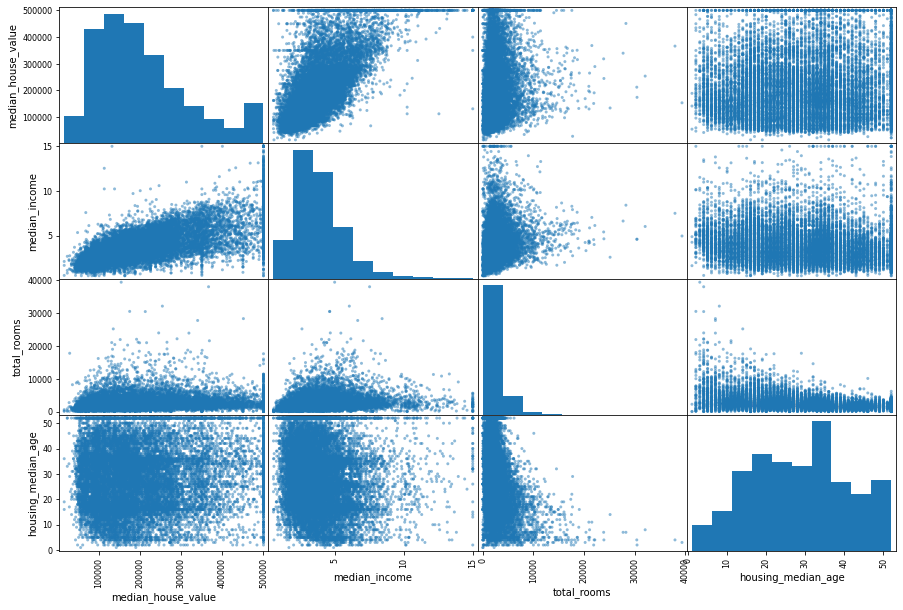

In [27]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15, 10))

The above scatter matrix plots every numerical attribute agaisnst every other numerical attribute, plus a histogram of each numerical attribute.

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

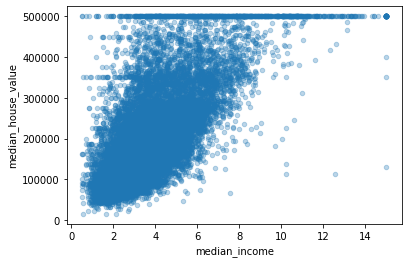

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.3)

Above we show median income vs. median house value.
The correlation is very strong. you can clearly see the upward trend and points are not too dispersed. Second, the price cap is visible as a horizontal line at $ 500,000. There is a horizontal line at $450,000 and another at $ 350,000

In [29]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

Above we notice the total number of rooms in a district is not very useful if we don't know how many households there are. we will apply the number of rooms per household. Then the total number of bedrooms by itself is not very useful, so we will compare it to the number of rooms. And the population per household also seems like an intreresting combination to consider.

In [30]:
cor_matrix = housing.corr()
cor_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In the above corolation matirx, the new bedrooms_per_room attribute is much more correlated with median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. Median_house_value and median_income has a positive corrolation.

In [31]:
# revert to clean training set and copy strat_train_set and separate
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [32]:
# housing.dropna(subset=["total)bedrooms"])
# housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [33]:
# making all continous values the average value 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [34]:
# because median can only be computed on numerical attributes, 
#we create a copy of the data without the text attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)

In [35]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [36]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [37]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

now we can use this trained imputer to transform the training set by replacing missing vlaues with learned medians.

In [38]:
x = imputer.transform(housing_num)

save this function just in case I want to return data frame back
 housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing_num.index)

In [39]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(9)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN


Above there are limited number of possible values, but most machine learning algorithms perfer to work with numbers. Time to convert ocean_proximity into numbers. in the code below we simplify our category texts and compressed them for our machine learning model


In [40]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [41]:
# checking for the list of categories and seeing the sparse matrix
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [42]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
# # used SciPy sparce matrix .  we get a matrix of columns filled iwth 0s and 1s 
# housing_cat_1hot.toarray()

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

The  add_bedrooms_per_room above will alllow us to eaily find out whether adding this attributes helps the Machine Learning algorithms or not.

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline ([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
                                      
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Above we import pipeline and preprocessing with standardazing the data.

## Below we will train the Linear Regression model.

In [48]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [49]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [50]:
the_data = housing.iloc[:5]
the_labels = housing_labels.iloc[:5]
the_data_prepared = full_pipeline.transform(the_data)
print("Pridictions:", lin_reg.predict(the_data_prepared))

Pridictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [51]:
print("labels:", list(the_labels))

labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


Below we will measure our linear regression model with Root Mean Square Error(RMSE)

In [52]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

The above result is an ok score but not the best or what I'm looking for. More districts Median_housing_values range between $ 120,000 and $ 265,000, so an error of $68,627 is not what we are looking for. Perhaps features we have do not provide enough information to make good predictions. Or our model is not complex enough. Next we will try decisoin tree model. It seems like our model is underfitting the training data. Maybe our features do not provide enough information to make good predictions or our model is not powerful enough.

## Below we will apply Decision Tree Regressor

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

Above we've trained the decision tree model now its time to try it on our training data.

In [54]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The decision tree model above shows perfections, or maybe this model is overfit. Lets use cross-validation to test it.

In [55]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [56]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [73719.42398172 71833.52803307 69297.25792783 72905.82870413
 69975.9668368  77493.85690856 69193.78416864 73170.94777702
 68576.93301257 69495.5438835 ]
Mean: 71566.30712338226
Standard deviation: 2659.7632411248087


Above we have the cross validation scores and the decision tree performed worse than the linear regression. It seems the decision tree overfit, but when we cross valided using 10 folds it did not perform well neither.

## Below we have the linear regression cross validation scores

In [57]:
# checking linear regression cross validation scores
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)

In [58]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


## Below we will use random forest to see how well it does and compare it to our previous models

In [66]:
# create randomforest regrssor to fit our data
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [67]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18857.042572430713

In [70]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

Below the random forest performed much better than the linear regression and the decision tree models.

In [71]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(forest_rmse_scores)

Scores: [51754.76581308 48835.07287782 46834.28544709 51994.95668543
 47723.05866159 52515.4424461  52482.43913736 49532.15471989
 49006.37183209 53742.38949866]
Mean: 50442.093711911744
Standard deviation: 2221.923997252075


## In the cells below we will apply gridsearchCV to find the best hyperparameters which will help us fine-tune our model

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap":[False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

In [74]:
forest_reg = RandomForestRegressor()

In [75]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                            scoring="neg_mean_squared_error",
                            return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [76]:
# best paramaters are 6 for max_features and 30 for n_estimators
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [77]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [78]:
# looking at the evaluation scores for our hyperparameters
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),params)

63765.85253120903 {'max_features': 2, 'n_estimators': 3}
55769.1263344864 {'max_features': 2, 'n_estimators': 10}
52427.521919637955 {'max_features': 2, 'n_estimators': 30}
60687.58124982688 {'max_features': 4, 'n_estimators': 3}
52990.353891938605 {'max_features': 4, 'n_estimators': 10}
50448.47179445883 {'max_features': 4, 'n_estimators': 30}
59620.589167896374 {'max_features': 6, 'n_estimators': 3}
52102.915516345456 {'max_features': 6, 'n_estimators': 10}
49917.637318545145 {'max_features': 6, 'n_estimators': 30}
59722.805147989624 {'max_features': 8, 'n_estimators': 3}
51756.59093429513 {'max_features': 8, 'n_estimators': 10}
49988.943412057044 {'max_features': 8, 'n_estimators': 30}
62047.47917063292 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54596.79162490614 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60377.440795448994 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52642.01625851618 {'bootstrap': False, 'max_features': 3, 'n_estimato

In the above we obtained the best solution by setting max_features hyperamaters to 6 and the n_estimators hypermaters to 30. The RMSE score for this combination is 49844, which is slightly better than the score we got earlier using the default hyperameter value which was 50334

### Applying Support Vector Machine to our dataset

In [79]:
from sklearn.svm import SVR
svm_reg = SVR(kernel = "rbf")
svm_reg.fit(housing_prepared, housing_labels)

SVR()

In [80]:
housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_rmse)
svm_rmse

118578.69234925653

In [81]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
svmr_rmse_scores = np.sqrt(-scores)

In [82]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(svmr_rmse_scores)

Scores: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
Mean: 118584.55594251942
Standard deviation: 2609.6120823493407


## Analyzing the best models and their errors

In [86]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.76133172e-02, 6.70037266e-02, 4.26810773e-02, 1.78181573e-02,
       1.69069954e-02, 1.73820743e-02, 1.60860711e-02, 3.52078890e-01,
       5.30247818e-02, 1.08930175e-01, 8.05536918e-02, 1.55864391e-02,
       1.23201707e-01, 6.74943032e-05, 3.69697771e-03, 7.36842440e-03])

In [87]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35207888983574925, 'median_income'),
 (0.12320170706899407, 'INLAND'),
 (0.10893017480319254, 'pop_per_hhold'),
 (0.08055369179375081, 'bedrooms_per_room'),
 (0.07761331717921238, 'longitude'),
 (0.06700372662073317, 'latitude'),
 (0.05302478183370313, 'rooms_per_hhold'),
 (0.04268107731772464, 'housing_median_age'),
 (0.017818157268819836, 'total_rooms'),
 (0.017382074309697283, 'population'),
 (0.016906995353696233, 'total_bedrooms'),
 (0.016086071092430047, 'households'),
 (0.015586439107969153, '<1H OCEAN'),
 (0.007368424396173763, 'NEAR OCEAN'),
 (0.0036969777149367428, 'NEAR BAY'),
 (6.749430321688677e-05, 'ISLAND')]

In [88]:
final_model = grid_search.best_estimator_

In [91]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [93]:
X_test_prepared = full_pipeline.transform(X_test)

In [94]:
final_predictions = final_model.predict(X_test_prepared)

In [95]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

## Lets see how presice this estimate is by computing the confidence interval

In [96]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

array([45628.09354423, 49434.16773696])

Overall it seems the Random Forest Regressor Model performed well than the Linear Regression, Decision Tree and the Support Vector Model